In [1]:
import sys, os
# Append ../src to the system path
sys.path.append("../src")

import config
from utils import *

## Set up a retry helper to handle per-minute quota limits during "Run all."

In [2]:
from google.api_core import retry
from google import genai
from google.genai import types

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

GOOGLE_API_KEY = config.GOOGLE_API_KEY
client = genai.Client(api_key=GOOGLE_API_KEY)

# Generate recipe from text

In [3]:
response = generate_recipe(["chicken", "rice", "broccoli"])

In [4]:
print(response)

{'title': 'Ginger-Glazed Chicken with Coconut Rice and Sesame Broccoli', 'cooking_time': '45 minutes', 'ingredients': ['Chicken breasts: 2, boneless, skinless', 'Rice: 1 cup, jasmine or basmati', 'Broccoli florets: 1 head', 'Soy sauce: 1/4 cup', 'Honey: 2 tablespoons', 'Fresh ginger: 1 tablespoon, grated', 'Garlic: 2 cloves, minced', 'Sesame oil: 1 tablespoon', 'Coconut milk: 1 can (13.5 oz)', 'Sesame seeds: 1 tablespoon', 'Vegetable oil: 2 tablespoons', 'Salt: to taste', 'Pepper: to taste'], 'instructions': ['Prepare the rice: Rinse rice until water runs clear. Combine rice and coconut milk in a saucepan. Bring to a boil, then reduce heat to low, cover, and simmer for 18-20 minutes, or until all liquid is absorbed. Fluff with a fork.', 'Prepare the ginger glaze: In a small bowl, whisk together soy sauce, honey, grated ginger, and minced garlic.', 'Cook the chicken: Heat 1 tablespoon of vegetable oil in a large skillet over medium-high heat. Season chicken breasts with salt and pepper.

# Generate recipe from Image

In [5]:
image_path=os.path.join(config.ROOT_PATH, "data/ingredients.jpg")
raw_ingredients=detect_ingredients(image_path)
response = generate_recipe(raw_ingredients)

print(response)

{'title': 'Spicy Cilantro-Lime Shrimp Skewers', 'cooking_time': '25 minutes', 'ingredients': ['Shrimp (peeled and deveined): 1 pound', 'Fresh coriander (chopped): 1/2 cup', 'Lemon juice: 3 tablespoons', 'Green chili (finely chopped): 1-2 (to taste)', 'Ginger (grated): 1 tablespoon', 'Salt: 1 teaspoon', 'Cumin powder: 1/2 teaspoon', 'Olive oil: 2 tablespoons', 'Wooden skewers: 10-12'], 'instructions': ['Soak wooden skewers in water for at least 30 minutes to prevent burning.', 'In a bowl, combine chopped coriander, lemon juice, green chili, grated ginger, salt, cumin powder, and olive oil.', 'Add the shrimp to the marinade and toss well to coat. Let it marinate for at least 15 minutes (or up to 30 minutes in the refrigerator).', 'Thread the marinated shrimp onto the soaked skewers.', 'Preheat a grill or grill pan to medium-high heat.', 'Grill the shrimp skewers for 2-3 minutes per side, or until the shrimp are pink and cooked through.', 'Serve immediately.'], 'tip': 'Serve with a side o

Here are the instructions for the dish.

In [6]:
response["instructions"]

['Soak wooden skewers in water for at least 30 minutes to prevent burning.',
 'In a bowl, combine chopped coriander, lemon juice, green chili, grated ginger, salt, cumin powder, and olive oil.',
 'Add the shrimp to the marinade and toss well to coat. Let it marinate for at least 15 minutes (or up to 30 minutes in the refrigerator).',
 'Thread the marinated shrimp onto the soaked skewers.',
 'Preheat a grill or grill pan to medium-high heat.',
 'Grill the shrimp skewers for 2-3 minutes per side, or until the shrimp are pink and cooked through.',
 'Serve immediately.']

In [7]:
images = generate_step_images(response)

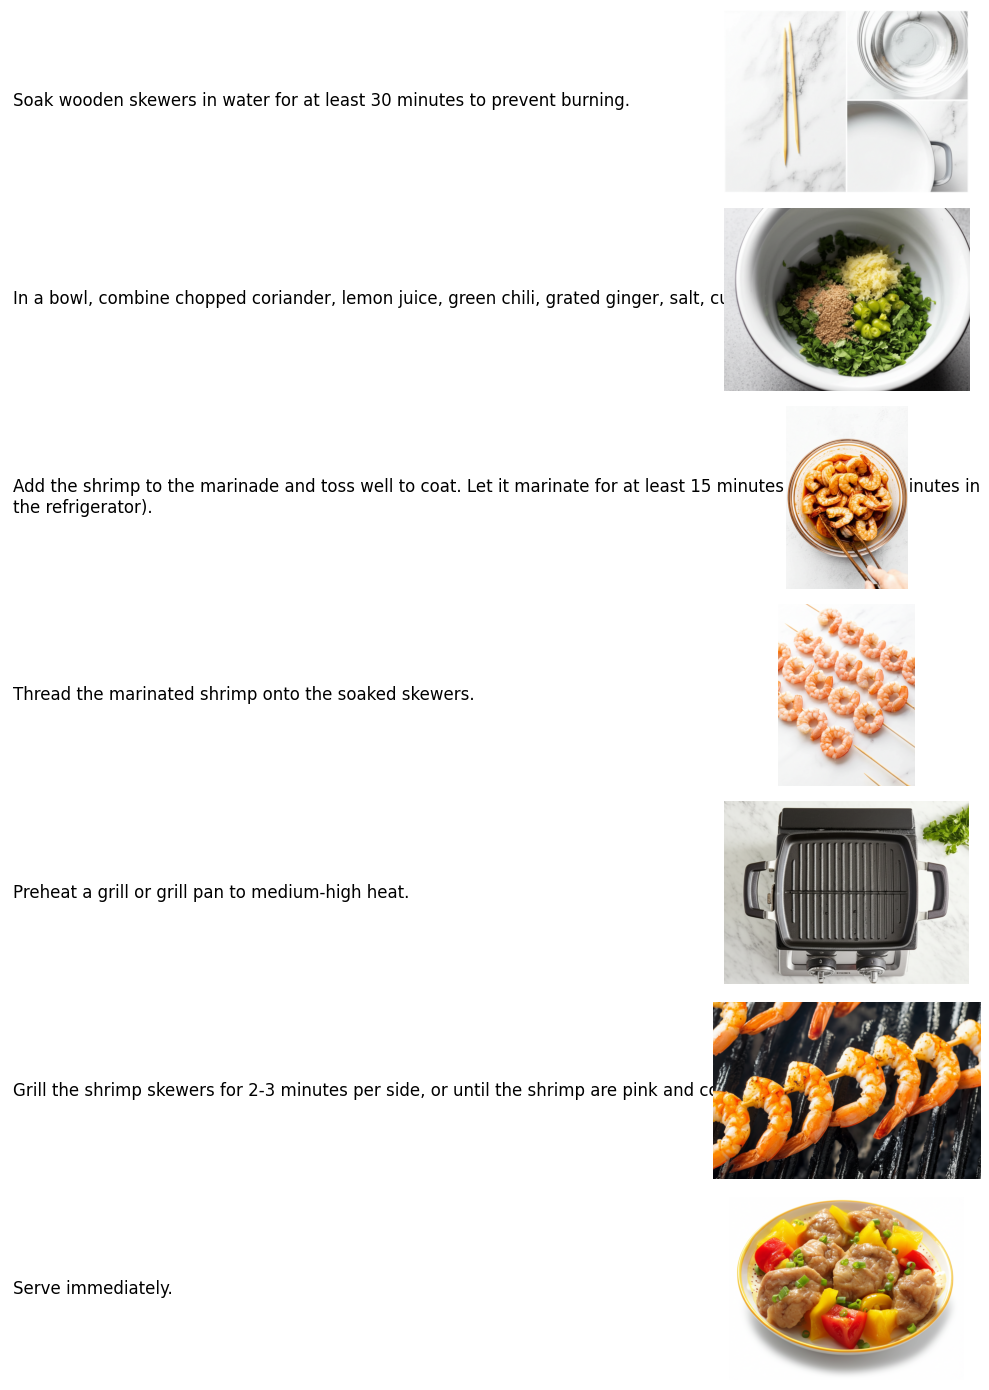

In [8]:
show_images_with_text(images, response["instructions"])

# Get nutrients from ingredients

In [9]:
response["ingredients"]

['Shrimp (peeled and deveined): 1 pound',
 'Fresh coriander (chopped): 1/2 cup',
 'Lemon juice: 3 tablespoons',
 'Green chili (finely chopped): 1-2 (to taste)',
 'Ginger (grated): 1 tablespoon',
 'Salt: 1 teaspoon',
 'Cumin powder: 1/2 teaspoon',
 'Olive oil: 2 tablespoons',
 'Wooden skewers: 10-12']

In [10]:
get_nutrition_info(response)

{'protein (in g)': 92,
 'fat (in g)': 31,
 'carbohydrates (in g)': 15,
 'calories (in kcal)': 708}